##Librerias

Cargamos de las librerias todos los paquetes que necesitamos para desarrollar el modelo.

In [ ]:
import pandas as pd
import numpy as np
import os
import re
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, Input, Model
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import random

Función para generar una semilla aleatoria utilizando fuentes del sistema operativo. Esto garantiza alta entropía para inicializar de forma robusta los generadores aleatorios.

In [ ]:
def get_random_seed_through_os():
    RAND_SIZE = 4
    random_data = os.urandom(RAND_SIZE)
    random_seed = int.from_bytes(random_data, byteorder="big")
    return random_seed


RANDOM_SEED = get_random_seed_through_os()
print(f"Random seed usada: {RANDOM_SEED}")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Random seed usada: 3221380369


##Rutas

Definimos las rutas que se van a ocupar durante todo el proceso

In [ ]:
ruta = '/content/drive/MyDrive/DIMEMEX/public_data_1/train_labels_tasks_1_3.csv'
ruta_images_train = '/content/drive/MyDrive/DIMEMEX/train'
ruta_images_validation = '/content/drive/MyDrive/DIMEMEX/validation'

##Imagenes y Etiquetas

Cargamos las imagenes en el orden en el que vienen en los JSON debido a que asi estan las etiquetas en el CSV.

In [ ]:
with open('/content/drive/MyDrive/DIMEMEX/public_data_1/train_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

orden_imagenes_train = [item["MEME-ID"] for item in data]
print(f"El tamaño del conjunto de entrenamiento es de: {len(orden_imagenes_train)}")

with open('/content/drive/MyDrive/DIMEMEX/public_data_1/validation_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

orden_imagenes_validation = [item["MEME-ID"] for item in data]
print(f"El tamaño del conjunto de entrenamiento es de: {len(orden_imagenes_validation)}")


El tamaño del conjunto de entrenamiento es de: 2263
El tamaño del conjunto de entrenamiento es de: 323


In [ ]:
images_train = [os.path.join(ruta_images_train, nombre) for nombre in orden_imagenes_train]
images_train = [os.path.basename(path) for path in images_train]
print(images_train)
images_procesing_train = []
len(images_train)

['DS_IMG_2448.jpg', 'DS_IMG_3105.jpg', 'DS_IMG_2663.jpg', 'DS_IMG_1681.jpg', 'DS_IMG_3063.jpg', 'DS_IMG_2385.jpg', 'DS_IMG_1574.jpg', 'DS_IMG_1510.jpg', 'DS_IMG_1511.jpg', 'DS_IMG_3072.jpg', 'DS_IMG_1395.jpg', 'DS_IMG_370.jpg', 'DS_IMG_3015.jpg', 'DS_IMG_3287.jpg', 'DS_IMG_1565.jpg', 'DS_IMG_1838.jpg', 'DS_IMG_2296.jpg', 'DS_IMG_400.jpg', 'DS_IMG_2494.jpg', 'DS_IMG_1724.jpg', 'DS_IMG_1998.jpg', 'DS_IMG_2098.jpg', 'DS_IMG_2030.jpg', 'DS_IMG_862.jpg', 'DS_IMG_1491.jpg', 'DS_IMG_2377.jpg', 'DS_IMG_2738.jpg', 'DS_IMG_3006.jpg', 'DS_IMG_2561.jpg', 'DS_IMG_3147.jpg', 'DS_IMG_2405.jpg', 'DS_IMG_1875.jpg', 'DS_IMG_1863.jpg', 'DS_IMG_834.jpg', 'DS_IMG_2947.jpg', 'DS_IMG_2318.jpg', 'DS_IMG_60.jpg', 'DS_IMG_1376.jpg', 'DS_IMG_2605.jpg', 'DS_IMG_1482.jpg', 'DS_IMG_2515.jpg', 'DS_IMG_596.jpg', 'DS_IMG_719.jpg', 'DS_IMG_704.jpg', 'DS_IMG_232.jpg', 'DS_IMG_2532.jpg', 'DS_IMG_1053.jpg', 'DS_IMG_2480.jpg', 'DS_IMG_2789.jpg', 'DS_IMG_3201.jpg', 'DS_IMG_889.jpg', 'DS_IMG_2199.jpg', 'DS_IMG_2339.jpg', 'DS

2263

In [ ]:
images_validation = [os.path.join(ruta_images_validation, nombre) for nombre in orden_imagenes_validation]
images_validation = [os.path.basename(path) for path in images_validation]
print(images_validation)
images_procesing_validation = []
len(images_validation)

['DS_IMG_2498.jpg', 'DS_IMG_178.jpg', 'DS_IMG_445.jpg', 'DS_IMG_1960.jpg', 'DS_IMG_1294.jpg', 'DS_IMG_707.jpg', 'DS_IMG_865.jpg', 'DS_IMG_996.jpg', 'DS_IMG_551.jpg', 'DS_IMG_163.jpg', 'DS_IMG_190.jpg', 'DS_IMG_505.jpg', 'DS_IMG_3115.jpg', 'DS_IMG_3241.jpg', 'DS_IMG_844.jpg', 'DS_IMG_872.jpg', 'DS_IMG_1425.jpg', 'DS_IMG_177.jpg', 'DS_IMG_444.jpg', 'DS_IMG_1347.jpg', 'DS_IMG_1411.jpg', 'DS_IMG_2188.jpg', 'DS_IMG_2316.jpg', 'DS_IMG_2342.jpg', 'DS_IMG_1909.jpg', 'DS_IMG_1173.jpg', 'DS_IMG_662.jpg', 'DS_IMG_1167.jpg', 'DS_IMG_448.jpg', 'DS_IMG_951.jpg', 'DS_IMG_378.jpg', 'DS_IMG_87.jpg', 'DS_IMG_3294.jpg', 'DS_IMG_2993.jpg', 'DS_IMG_3166.jpg', 'DS_IMG_358.jpg', 'DS_IMG_2205.jpg', 'DS_IMG_1867.jpg', 'DS_IMG_894.jpg', 'DS_IMG_2603.jpg', 'DS_IMG_2517.jpg', 'DS_IMG_943.jpg', 'DS_IMG_499.jpg', 'DS_IMG_3196.jpg', 'DS_IMG_2358.jpg', 'DS_IMG_1432.jpg', 'DS_IMG_1742.jpg', 'DS_IMG_433.jpg', 'DS_IMG_2611.jpg', 'DS_IMG_332.jpg', 'DS_IMG_2020.jpg', 'DS_IMG_1652.jpg', 'DS_IMG_258.jpg', 'DS_IMG_1212.jpg',

323

Procesar las imagenes

In [ ]:
for img_file in images_train:
  image_temporal  = os.path.join(ruta_images_train, img_file)
  img = image.load_img(image_temporal, target_size = (128, 128))
  img = image.img_to_array(img) / 255.0
  images_procesing_train.append(img)

In [ ]:
for img_file in images_validation:
  image_temporal  = os.path.join(ruta_images_validation, img_file)
  img = image.load_img(image_temporal, target_size = (128, 128))
  img = image.img_to_array(img) / 255.0
  images_procesing_validation.append(img)

Observamos como proceso una de las imagenes del entrenamiento

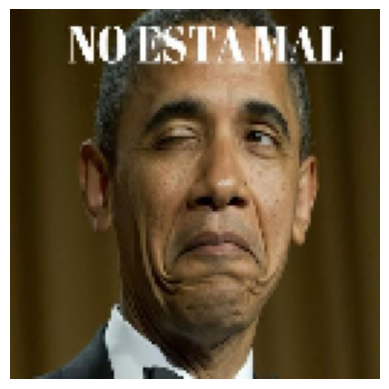

In [ ]:
img_sample = images_procesing_train[0]

plt.imshow(img_sample)
plt.axis('off')
plt.show()

Los transformamos a arreglos para que se puedan meter a la red neuronal

In [ ]:
images_procesing_train = np.array(images_procesing_train)
images_procesing_validation = np.array(images_procesing_validation)
labels = pd.read_csv(ruta, header = None).values

Definicion del modelo de la red neuranl CNN

In [ ]:
def build_cnn_model():
    inputs = Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(128, activation=None, name='embedding_layer')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Dense)         │ (None, 128)            │     3,211,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,640 (12.61 MB)

 Trainable params: 3,304,640 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
embedding_model = Model(inputs=cnn_model.input,outputs=cnn_model.get_layer('embedding_layer').output)

Obtenemos los embeddings del entrenamiento y la validación

In [ ]:
embeddings_train = embedding_model.predict(images_procesing_train, batch_size = 64, verbose = 1)
print(embeddings_train.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 841ms/step
(2263, 128)


In [ ]:
embeddings_validation = embedding_model.predict(images_procesing_validation, batch_size = 64, verbose = 1)
print(embeddings_validation.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step
(323, 128)


Antes de pasar a la extracción de embeddings del texto, vemos como se relacionan los embeddigs de la imagen y ver a criterio propio si tienen alguna relación


🔍 Memes más similares a 'DS_IMG_2448.jpg':



<ipython-input-16-905fd5f9e1ac>:23: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


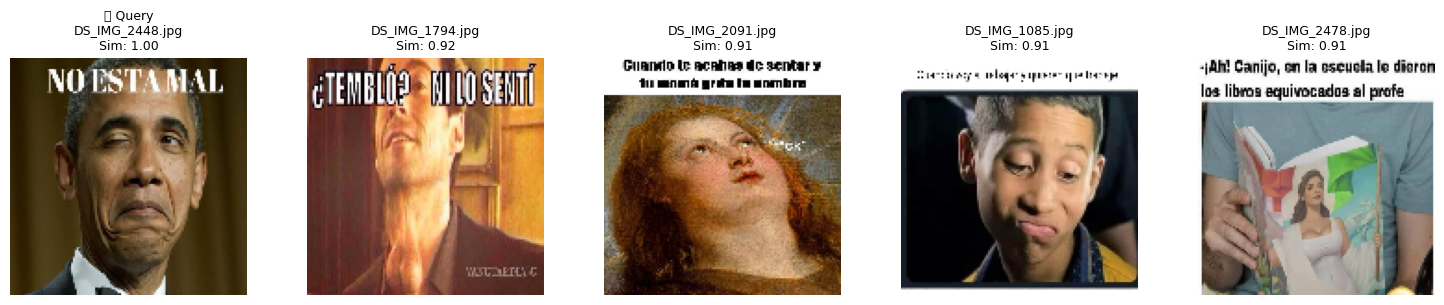

In [ ]:
def find_similar_memes(query_idx, embeddings, image_names, ruta_images, top_k=5):
    query_embedding = embeddings[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, embeddings)
    top_indices = np.argsort(similarities[0])[-top_k:][::-1]

    print(f"\n🔍 Memes más similares a '{image_names[query_idx]}':\n")

    plt.figure(figsize=(15, 3))

    for i, idx in enumerate(top_indices):
        img_path = os.path.join(ruta_images, image_names[idx])
        img = image.load_img(img_path, target_size=(128, 128))

        plt.subplot(1, top_k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        sim_score = similarities[0][idx]
        if idx == query_idx:
            plt.title(f"🎯 Query\n{image_names[idx]}\nSim: {sim_score:.2f}", fontsize=9)
        else:
            plt.title(f"{image_names[idx]}\nSim: {sim_score:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()


find_similar_memes(
    query_idx=0,                      # O el índice que tú quieras comparar
    embeddings=embeddings_train,
    image_names=images_train,         # Solo los nombres tipo 'DS_IMG_2448.jpg'
    ruta_images="/content/drive/MyDrive/DIMEMEX/train",  # Ruta base
    top_k=5                          # Número de memes similares
)

Obtenemos los textos y los limpiamos (un preprocesamiento)

In [ ]:
ruta_json_train = '/content/drive/MyDrive/DIMEMEX/public_data_1/train_data.json'

# Función de limpieza
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)  # Quitar símbolos raros
    texto = re.sub(r'\s+', ' ', texto)
    texto = texto.strip()
    return texto

# Cargar JSON y limpiar
with open(ruta_json_train, 'r', encoding='utf-8') as f:
    datos = json.load(f)

textos_train = [limpiar_texto(item['text']) for item in datos]

#Ver testos limpios
for t in textos_train:
    print(t)

no está mal
no creas que porque te enamoras de un feo no te lo van a quitar siempre hay una más ciega que tú
se acabó todo todo todillo
pero esa mujer te hizo brujería la brujería
después de los memes racistas y xenófobos seguimos siendo hermanos porque somos seres civilizados
tu y yo así el piénsalo mi love
el mero mero de los albures del cocowash y de los masajes
cuando pregunto el precio de algo y está caro asta luego gracias
elle uwu siendo reconocido por la rae
fue un trabajo de equipo
muy rico y todo pero cabalgás como endemoniada y no aguanto ni minutos
dejad de educarme para ser esclava
ustedes se cren que odio el fútbol es cierto
si ves algo que te apetezca cógelo
están robando una lata de atún parece una michión para mí
no se asusten estamos moviendo a méxico
horóscopo algo positivo llegará a tu vida este mes
el sexismo sigue siendo sexismo aunque se dirija a los hombres
ingeniería civil ah un albañil con título
piensa que no entiendo albures si supiera
yo cuando ochoa paro e

In [ ]:
ruta_json_validation = '/content/drive/MyDrive/DIMEMEX/public_data_1/validation_data.json'

# Función de limpieza
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúüñ\s]', '', texto)  # Quitar símbolos raros
    texto = re.sub(r'\s+', ' ', texto)
    texto = texto.strip()
    return texto

# Cargar JSON y limpiar
with open(ruta_json_validation, 'r', encoding='utf-8') as f:
    datos = json.load(f)

textos_validation = [limpiar_texto(item['text']) for item in datos]

#Ver testos limpios
for t in textos_validation:
    print(t)

esta es mi película de facebook basta
la jevita cuando martha debayle le pide un vaso de agua con una jarrita mamarra y una servilleta coctelera te parece que somos ricos
el principio de pitufina sabes identificar cuando un cuento o una peli es sexista
si estás triste porque vas a pasar solo el san valentín recuerda que también vas a estar solo el resto del año
míralos ahí muy rudos pero uno fue niñera y el otro un hada
mi cara cuando salgo del trabajo sabendo que no hice nada en todo el día
ella era bella frágil como una rosa él era una bestia esclavo de sus impulsos
bienvenidos hoy les enseñaré a bailar el gusanito
por ser el día de la mujer pones wifi en la cocina v hazlo para mantener contenta a la babosa xdxd
premios de la academia clasismo racismo y hasta sergio goyri alfonso cuarón
que pase el desgraciado
when le quitas su lonchera a un niño venezolano v no hay nada v
mamá qué es el vibrador una polla de goma que me frotó por el chocho para darme el placer que tu padre ya no me 

Extraemos Embbedings con un modelo de BERT

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Obtener embeddings
embeddings_text_train = model.encode(textos_train, show_progress_bar=True)
embeddings_text_validation = model.encode(textos_validation, show_progress_bar=True)

print(f"Tamaño de los embeddings: {embeddings_text_train.shape}")
print(f"Tamaño de los embeddings: {embeddings_text_validation.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Tamaño de los embeddings: (2263, 384)
Tamaño de los embeddings: (323, 384)


In [ ]:
for i in range(5):
    print(f"Texto: {textos_train[i]}")
    print(f"Embedding: {embeddings_text_train[i]}")
    print()

Texto: no está mal
Embedding: [ 3.82339060e-02  2.07348708e-02  1.40624410e-02  1.66735966e-02
 -1.36541620e-01  1.28996773e-02  7.26725832e-02 -6.92921877e-02
  4.53076288e-02  1.03423726e-02  3.21915299e-02 -8.61287303e-03
 -1.05995707e-01 -1.08640548e-02  2.48793159e-02  2.19593290e-02
  1.55682908e-02  1.37234405e-02  3.15133929e-02 -6.04590075e-03
  3.32323909e-02  2.61612087e-02 -6.92385584e-02  1.56782512e-02
 -7.49267489e-02 -7.97192939e-03  6.55782744e-02  3.99958827e-02
 -1.96589772e-02 -7.99144879e-02  2.61042044e-02  3.02857440e-02
  4.94062016e-03 -2.09655426e-03  5.88447489e-02 -2.31419760e-03
  1.18026741e-01 -9.24002081e-02  4.68478501e-02  4.29927818e-02
 -2.29433496e-02 -9.36740339e-02 -6.49616048e-02  2.19521057e-02
 -4.88466409e-04 -4.53651547e-02 -1.07543461e-01  6.66995421e-02
  7.12204874e-02  1.15550859e-02 -4.14106511e-02 -2.80127320e-02
 -2.20617037e-02  1.66368634e-02  7.63133168e-02 -1.05233639e-02
  5.27670942e-02  8.20266607e-04  4.17952538e-02  6.93881959

In [ ]:
for i in range(5):
    print(f"Texto: {textos_validation[i]}")
    print(f"Embedding: {embeddings_text_validation[i]}")
    print()

Texto: esta es mi película de facebook basta
Embedding: [ 2.80392263e-03  9.13870893e-03 -4.67410870e-02 -1.95001792e-02
 -5.26798181e-02  1.42321261e-02  5.07713966e-02  8.05492222e-04
  5.27916439e-02  1.11336093e-02  6.81156889e-02 -3.07429284e-02
 -1.31508885e-02 -6.97459211e-04  1.10945210e-01  2.60737352e-02
 -1.61103215e-02  1.41765140e-02 -3.48659046e-02  2.85788383e-02
  9.37592518e-03 -6.57304674e-02 -5.57498075e-02  8.35497007e-02
 -3.36477458e-02 -2.70772297e-02  4.02232492e-03 -5.59780002e-02
 -3.46805453e-02 -3.16552185e-02  3.92796658e-02  6.30759969e-02
  7.09326118e-02  4.91843978e-03 -4.54453193e-03 -2.39923894e-02
  1.32080959e-02 -1.16681218e-01  3.43203824e-03  4.61378358e-02
 -1.05138853e-01 -4.45955321e-02 -3.38325240e-02 -2.44474448e-02
  1.37878302e-02 -5.36728501e-02 -1.46754449e-02  6.90540895e-02
  4.35449742e-02 -2.79164631e-02 -7.41338208e-02 -1.36656435e-02
 -1.89063158e-02 -1.23164505e-02  1.78117901e-02 -7.78968334e-02
  1.03674447e-02  7.81228952e-03  

Combinamos los dos embeddings tanto del texto como de la imagen haciendo asi un Ensambel

In [ ]:
combined_embeddings_train = np.concatenate([embeddings_train, embeddings_text_train], axis=1)

print(f"Shape de combined_embeddings: {combined_embeddings_train.shape}")
print(len(combined_embeddings_train[0]))

Shape de combined_embeddings: (2263, 512)
512


In [ ]:
combined_embeddings_validation = np.concatenate([embeddings_validation, embeddings_text_validation], axis=1)

print(f"Shape de combined_embeddings: {combined_embeddings_validation.shape}")
print(len(combined_embeddings_validation[0]))

Shape de combined_embeddings: (323, 512)
512


Definimos nuestro modelo de MLP sencillo usando validación cruzada

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Datos
X = combined_embeddings_train
y = np.argmax(labels, axis=1)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

num_classes = len(np.unique(y))
input_dim = X.shape[1]

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\n🔁 Fold {fold + 1}")

    # Separar datos
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # One-hot encoding
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Crear modelo
    entrada = Input(shape=(input_dim,))
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(entrada)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    salida = Dense(num_classes, activation='softmax')(x)

    modelo = tf.keras.Model(inputs=entrada, outputs=salida)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    modelo.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping para evitar sobreentrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    modelo.fit(
        X_train, y_train_onehot,
        validation_data=(X_val, tf.keras.utils.to_categorical(y_val, num_classes=num_classes)),
        epochs=100,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluar
    y_pred_probs = modelo.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')

    print(f"✔️ Accuracy: {acc:.4f}, F1 score: {f1:.4f}")
    accuracies.append(acc)
    f1_scores.append(f1)

# Resultados promedios
print("\n📊 Resultados Promedio:")
print(f"Accuracy promedio: {np.mean(accuracies):.4f}")
print(f"F1-score promedio: {np.mean(f1_scores):.4f}")



🔁 Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✔️ Accuracy: 0.6468, F1 score: 0.5510

🔁 Fold 2
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
✔️ Accuracy: 0.6424, F1 score: 0.5345

🔁 Fold 3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✔️ Accuracy: 0.6137, F1 score: 0.5173

🔁 Fold 4
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✔️ Accuracy: 0.6305, F1 score: 0.5306

🔁 Fold 5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✔️ Accuracy: 0.6372, F1 score: 0.5321

📊 Resultados Promedio:
Accuracy promedio: 0.6341
F1-score promedio: 0.5331


Como el conjunto de datos no tenia etiquetas, se convierte en una tarea de prediccion por lo que las predecimos

In [ ]:
X_val = combined_embeddings_validation
y_pred_probs = modelo.predict(X_val)

# Obtener la clase con mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)

# Ver primeras predicciones
print("Predicciones (etiquetas enteras):", y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Predicciones (etiquetas enteras): [0 0 2 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Implementación de un modelo preentrenado CLIP

In [ ]:
pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

Cargamos tanto las imagenes como el texto, que es lo que se mandara al procesador de CLIP ya que trabaja con un aprendizaje contrastivo y puede manejar los dos modos

In [38]:
import open_clip
import torch
import os
import json
from PIL import Image
from tqdm import tqdm
import numpy as np


ruta_json = "/content/drive/MyDrive/DIMEMEX/public_data_1/train_data.json"
carpeta_imagenes = "/content/drive/MyDrive/DIMEMEX/train"


device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="laion2b_s34b_b88k",
    device=device
)

tokenizer = open_clip.get_tokenizer("ViT-B-16")

# Leer archivo JSON con los memes
with open(ruta_json, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Extraer embeddings
image_embeddings = []
text_embeddings = []
errores = []

for ejemplo in tqdm(dataset, desc="Procesando memes"):
    try:
        nombre_img = ejemplo["MEME-ID"]
        texto = ejemplo["text"]

        ruta_img = os.path.join(carpeta_imagenes, nombre_img)
        if not os.path.exists(ruta_img):
            errores.append(f"❌ Imagen no encontrada: {nombre_img}")
            continue

        # Procesar imagen y texto
        image = preprocess(Image.open(ruta_img).convert("RGB")).unsqueeze(0).to(device)
        text = tokenizer([texto]).to(device)

        with torch.no_grad():
            img_emb = model.encode_image(image).cpu().numpy()[0]
            txt_emb = model.encode_text(text).cpu().numpy()[0]

        image_embeddings.append(img_emb)
        text_embeddings.append(txt_emb)

    except Exception as e:
        errores.append(f"❌ Error con {nombre_img}: {e}")

# Convertir a arrays
image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)
combined_embeddings = np.concatenate([image_embeddings, text_embeddings], axis=1)

print("✅ Embeddings generados:")
print("Imagen:", image_embeddings.shape)
print("Texto :", text_embeddings.shape)
print("Combinado:", combined_embeddings.shape)

# Guardar los resultados
np.save("clip_image_embeddings.npy", image_embeddings)
np.save("clip_text_embeddings.npy", text_embeddings)
np.save("clip_combined_embeddings.npy", combined_embeddings)

# Ver errores
if errores:
    print("\n⚠️ Errores encontrados:")
    for err in errores[:5]:
        print(err)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Procesando memes: 100%|██████████| 2263/2263 [43:06<00:00,  1.14s/it]

✅ Embeddings generados:
Imagen: (2263, 512)
Texto : (2263, 512)
Combinado: (2263, 1024)


Intentamos primero con una particion de 80 - 20 de los datos de entrenamiento

In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Entradas
X = combined_embeddings
y = labels

# Separar en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=np.argmax(y, axis=1), random_state=42)

input_dim = X.shape[1]
num_classes = y.shape[1]

# Arquitectura
entrada = Input(shape=(input_dim,))
x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(entrada)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = Dropout(0.3)(x)

salida = Dense(num_classes, activation='softmax')(x)

modelo = Model(inputs=entrada, outputs=salida)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
modelo.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


modelo.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5085 - loss: 1.3469 - val_accuracy: 0.6071 - val_loss: 1.0780
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5773 - loss: 1.1470 - val_accuracy: 0.6181 - val_loss: 1.0406
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6160 - loss: 1.0297 - val_accuracy: 0.6269 - val_loss: 1.0118
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6342 - loss: 0.9818 - val_accuracy: 0.6358 - val_loss: 0.9874
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6708 - loss: 0.9095 - val_accuracy: 0.6115 - val_loss: 0.9767
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7032 - loss: 0.8343 - val_accuracy: 0.6291 - val_loss: 0.9672
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7255 - loss: 0.7691 - val_accuracy: 0.6137 - val_loss: 0.9702
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7394 - loss: 0.7507 - val_accuracy: 0.

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       281
           1       0.34      0.22      0.27        95
           2       0.54      0.34      0.42        77

    accuracy                           0.63       453
   macro avg       0.52      0.47      0.48       453
weighted avg       0.59      0.63      0.60       453



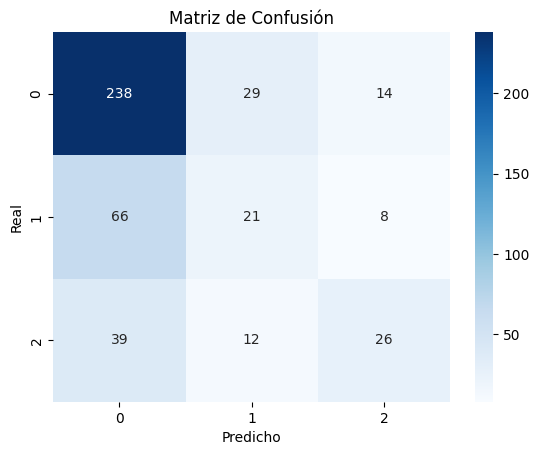

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predicciones
y_pred_probs = modelo.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Reporte
print(classification_report(y_true, y_pred))

# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


Ahora con validación cruzada

In [41]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Datos
X = combined_embeddings
y = labels

# Setup KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    input_dim = X.shape[1]
    num_classes = y.shape[1]

    # Crear modelo
    entrada = Input(shape=(input_dim,))
    x = Dense(512, activation='relu')(entrada)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    salida = Dense(num_classes, activation='softmax')(x)

    modelo = Model(inputs=entrada, outputs=salida)
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar
    modelo.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    # Predecir
    y_pred_probs = modelo.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Evaluar
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"✔️ Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Resultados finales
print("\n📊 Resultados promedio:")
print(f"Accuracy promedio: {np.mean(accuracies):.4f}")
print(f"F1-score promedio: {np.mean(f1_scores):.4f}")



🔁 Fold 1
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✔️ Accuracy: 0.5960, F1 Score: 0.5928

🔁 Fold 2
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
✔️ Accuracy: 0.6512, F1 Score: 0.6277

🔁 Fold 3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✔️ Accuracy: 0.6181, F1 Score: 0.6091

🔁 Fold 4
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
✔️ Accuracy: 0.6305, F1 Score: 0.6276

🔁 Fold 5
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✔️ Accuracy: 0.5597, F1 Score: 0.5651

📊 Resultados promedio:
Accuracy promedio: 0.6111
F1-score promedio: 0.6045


Obtenemos los de validación para poder hacer la predicción

In [42]:
import open_clip
import torch
import os
import json
from PIL import Image
from tqdm import tqdm
import numpy as np

# Rutas
ruta_json = "/content/drive/MyDrive/DIMEMEX/public_data_1/validation_data.json"
carpeta_imagenes = "/content/drive/MyDrive/DIMEMEX/validation"

# Cargar el modelo y preprocesador
device = "cuda" if torch.cuda.is_available() else "cpu"

model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="ViT-B-16",
    pretrained="laion2b_s34b_b88k",
    device=device
)

tokenizer = open_clip.get_tokenizer("ViT-B-16")

# Leer archivo JSON con los memes
with open(ruta_json, "r", encoding="utf-8") as f:
    dataset = json.load(f)

# Extraer embeddings
image_embeddings = []
text_embeddings = []
errores = []

for ejemplo in tqdm(dataset, desc="Procesando memes"):
    try:
        nombre_img = ejemplo["MEME-ID"]
        texto = ejemplo["text"]

        ruta_img = os.path.join(carpeta_imagenes, nombre_img)
        if not os.path.exists(ruta_img):
            errores.append(f"❌ Imagen no encontrada: {nombre_img}")
            continue

        # Procesar imagen y texto
        image = preprocess(Image.open(ruta_img).convert("RGB")).unsqueeze(0).to(device)
        text = tokenizer([texto]).to(device)

        with torch.no_grad():
            img_emb = model.encode_image(image).cpu().numpy()[0]
            txt_emb = model.encode_text(text).cpu().numpy()[0]

        image_embeddings.append(img_emb)
        text_embeddings.append(txt_emb)

    except Exception as e:
        errores.append(f"❌ Error con {nombre_img}: {e}")

# Convertir a arrays
image_embeddings = np.array(image_embeddings)
text_embeddings = np.array(text_embeddings)
combined_embeddings = np.concatenate([image_embeddings, text_embeddings], axis=1)

print("✅ Embeddings generados:")
print("Imagen:", image_embeddings.shape)
print("Texto :", text_embeddings.shape)
print("Combinado:", combined_embeddings.shape)

# Guardar los resultados
np.save("clip_image_embeddings.npy", image_embeddings)
np.save("clip_text_embeddings.npy", text_embeddings)
np.save("clip_combined_embeddings.npy", combined_embeddings)

# Ver errores
if errores:
    print("\n⚠️ Errores encontrados:")
    for err in errores[:5]:
        print(err)


Procesando memes: 100%|██████████| 323/323 [06:16<00:00,  1.17s/it]

✅ Embeddings generados:
Imagen: (323, 512)
Texto : (323, 512)
Combinado: (323, 1024)


Hacemos la predicción

In [43]:
X_val = combined_embeddings
y_pred_probs = modelo.predict(X_val)

# Obtener la clase con mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)

# Ver primeras predicciones
print("Predicciones (etiquetas enteras):", y_pred)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicciones (etiquetas enteras): [0 1 1 0 0 0 1 0 2 0 0 0 0 0 0 2 1 0 0 0 0 1 0 2 0 0 0 0 0 0 1 0 0 0 1 2 0
 0 1 0 0 0 1 0 0 0 0 0 0 2 0 0 0 1 0 2 0 0 1 0 1 0 1 0 0 2 0 0 0 1 0 0 0 1
 1 1 1 0 0 1 1 0 0 1 0 2 0 1 0 1 2 1 0 0 1 2 0 1 0 2 0 0 1 0 0 1 2 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 2 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 2 1 1 0
 0 0 2 2 0 0 0 2 1 1 0 2 0 0 0 1 1 0 1 1 0 2 0 2 0 0 1 2 2 0 0 1 0 0 1 0 0
 1 2 1 0 0 2 1 0 0 0 0 0 0 1 0 1 1 0 2 1 1 0 0 0 2 0 1 1 0 0 0 2 1 1 0 0 2
 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 1 1 2 0 2 1 0 0 0 0
 1 0 1 0 1 2 0 0 1 0 0 1 0 0 1 1 0 0 0 2 0 0 2 2 0 0 0 0 0 2 0 0 2 1 2 0 0
 0 1 0 0 2 0 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 2 0 0 1]
